In [4]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 83% 50.0M/60.3M [00:00<00:00, 179MB/s]
100% 60.3M/60.3M [00:00<00:00, 181MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fer2013.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
#import necessary libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [7]:
# specifing new image shape for resnetv2
img_shape = 224
batch_size = 64
train_data_path = '/content/train'
test_data_path = '/content/test'

train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)

test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [9]:
train_dir = "/content/train/" # Directory containing the training data
test_dir = "/content/test/"  # Directory containing the validation data

def Classes_Count( path, name):
    Classes_Dict = {}

    for Class in os.listdir(path):

        Full_Path = path + Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))

    df = pd.DataFrame(Classes_Dict, index=[name])

    return df

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

In [10]:
pd.concat([Train_Count,Test_Count] , axis=1)

,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


<Axes: >

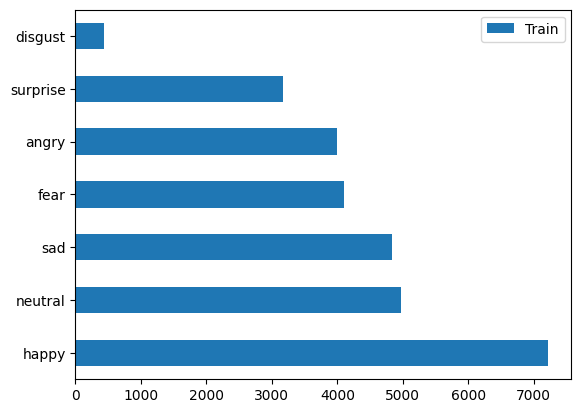

In [11]:
Train_Count.plot(kind='barh')

<Axes: >

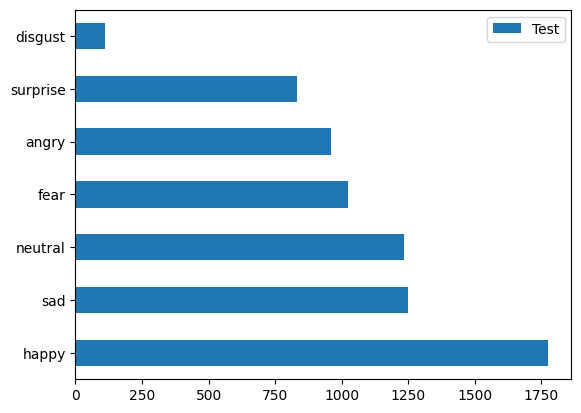

In [12]:
Test_Count.plot(kind='barh')

In [5]:
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

#ResNet50V2.summary()

94668760/94668760 [==============================] - 1s 0us/step


In [6]:
# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [7]:
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(.5),
                      Dense(7,activation='softmax') #best for multi class
                    ])
    return model

In [8]:
ResNet50V2_Model = Create_ResNet50V2_Model()

ResNet50V2_Model.summary()

ResNet50V2_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #one hot encoded

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 2048)        8192      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

In [9]:
# Create Callback Checkpoint
checkpoint_path = "ResNet50V2_Model_Checkpoint.h5"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True , save_weights_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.00005,
                                                  verbose=1)

callbacks = [Checkpoint,Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size #28000 / 64 = 448
validation_steps = test_data.n // test_data.batch_size #7000 / 64

In [10]:
ResNet50V2_history = ResNet50V2_Model.fit(train_data ,validation_data = test_data , epochs=15, batch_size=batch_size,
                                         callbacks = callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/15
448/448 [==============================] - 487s 1s/step - loss: 1.5063 - accuracy: 0.4774 - val_loss: 1.6328 - val_accuracy: 0.5379 - lr: 0.0010
Epoch 2/15
448/448 [==============================] - 438s 978ms/step - loss: 1.2183 - accuracy: 0.5599 - val_loss: 1.2542 - val_accuracy: 0.5974 - lr: 0.0010
Epoch 3/15
448/448 [==============================] - 438s 977ms/step - loss: 1.1086 - accuracy: 0.5992 - val_loss: 1.0471 - val_accuracy: 0.6208 - lr: 0.0010
Epoch 4/15
448/448 [==============================] - 409s 912ms/step - loss: 1.0450 - accuracy: 0.6190 - val_loss: 1.0970 - val_accuracy: 0.5956 - lr: 0.0010
Epoch 5/15
448/448 [==============================] - 431s 962ms/step - loss: 1.0138 - accuracy: 0.6285 - val_loss: 1.0359 - val_accuracy: 0.6243 - lr: 0.0010
Epoch 6/15
448/448 [==============================] - 434s 969ms/step - loss: 0.9875 - accuracy: 0.6418 - val_loss: 1.0179 - val_accuracy: 0.6323 - lr: 0.0010
Epoch 7/15
448/448 [=============================

In [11]:
ResNet50V2_score = ResNet50V2_Model.evaluate(test_data)

print("Test Loss: {:.5f}".format(ResNet50V2_score[0]))
print("Test Accuracy: {:.2f}%".format(ResNet50V2_score[1] * 100))

113/113 [==============================] - 21s 185ms/step - loss: 0.9292 - accuracy: 0.6811
Test Loss: 0.92920
Test Accuracy: 68.11%


In [12]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

  #plt.tight_layout()

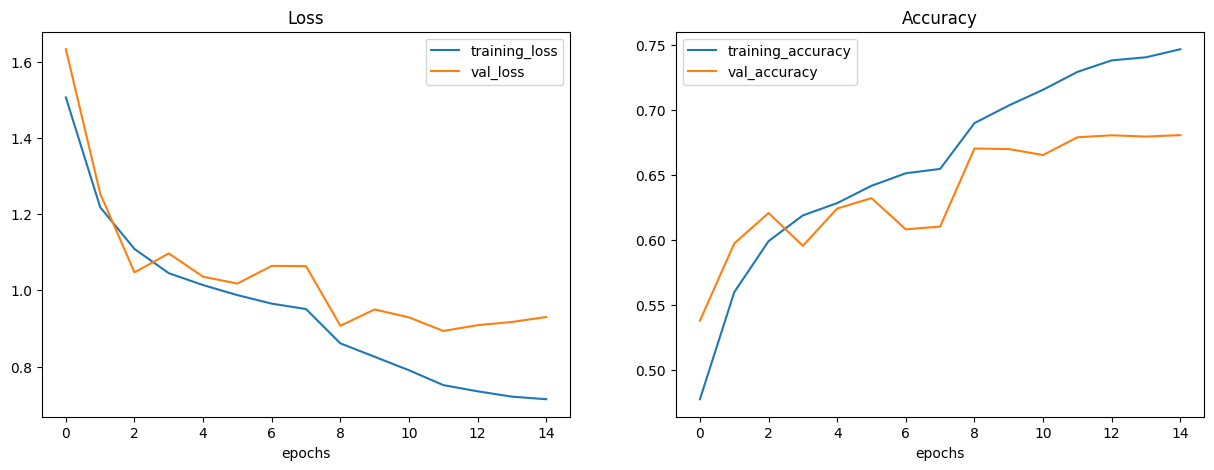

In [13]:
plot_curves(ResNet50V2_history)

In [16]:
ResNet50V2_Predictions = ResNet50V2_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction
ResNet50V2_Predictions = np.argmax(ResNet50V2_Predictions, axis=1)

113/113 [==============================] - 21s 174ms/step


In [14]:
test_data.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

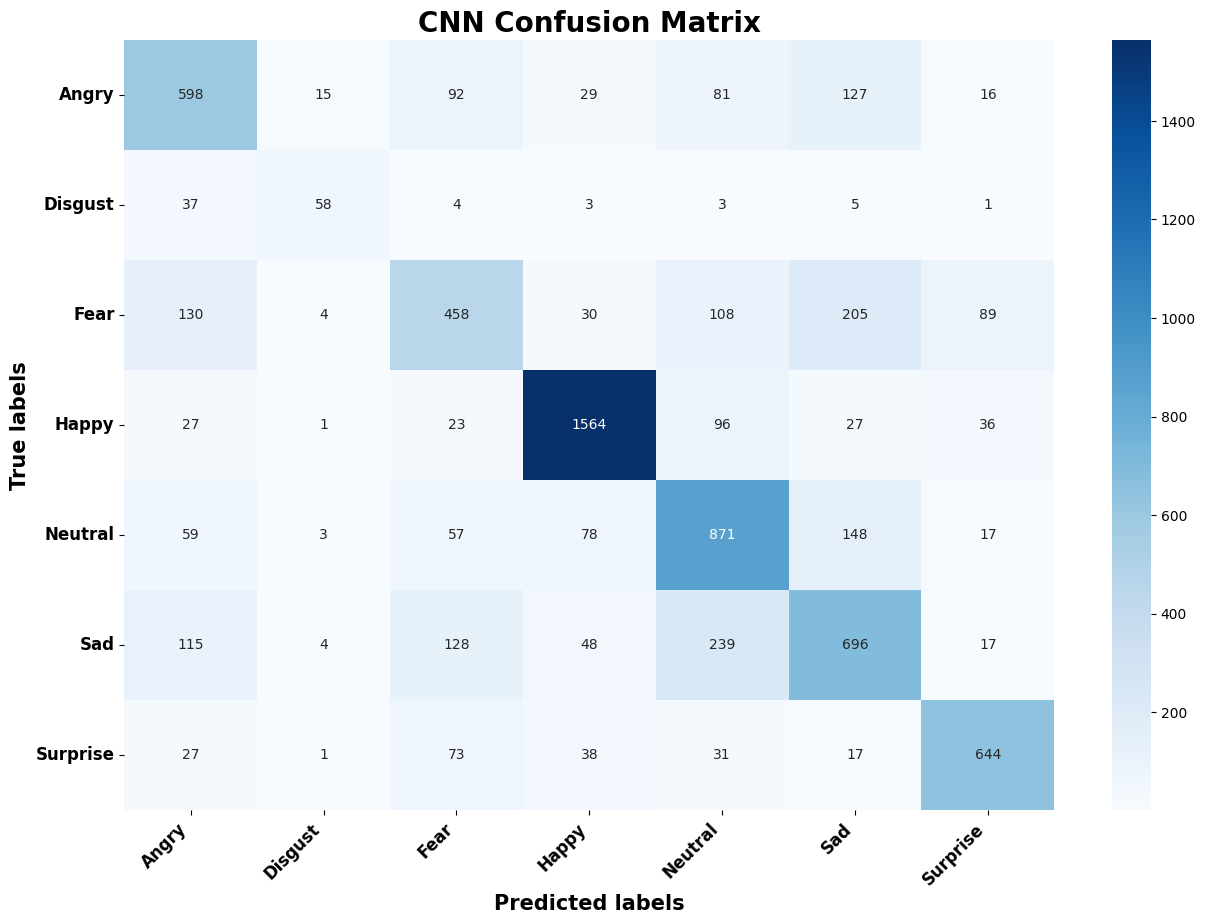

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Your confusion matrix generation
cm = confusion_matrix(test_data.labels, ResNet50V2_Predictions)

# Emotion classes
Emotion_Classes = ['Angry',
                   'Disgust',
                   'Fear',
                   'Happy',
                   'Neutral',
                   'Sad',
                   'Surprise']

# Create the plot
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the heatmap
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues')

# Set axis labels
ax.set_xlabel('Predicted labels', fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('ResNet50V2 Confusion Matrix', fontsize=20, fontweight='bold')

# Set the tick labels
ax.set_xticks(ticks=np.arange(len(Emotion_Classes)) + 0.5)
ax.set_yticks(ticks=np.arange(len(Emotion_Classes)) + 0.5)
ax.set_xticklabels(Emotion_Classes, rotation=45, ha='right', fontsize=12, fontweight='bold')
ax.set_yticklabels(Emotion_Classes, rotation=0, fontsize=12, fontweight='bold')

# Show the plot
plt.show()

In [18]:
Emotion_Classes = ['Angry',
                  'Disgust',
                  'Fear',
                  'Happy',
                  'Neutral',
                  'Sad',
                  'Surprise']

In [19]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 7178 images belonging to 7 classes.


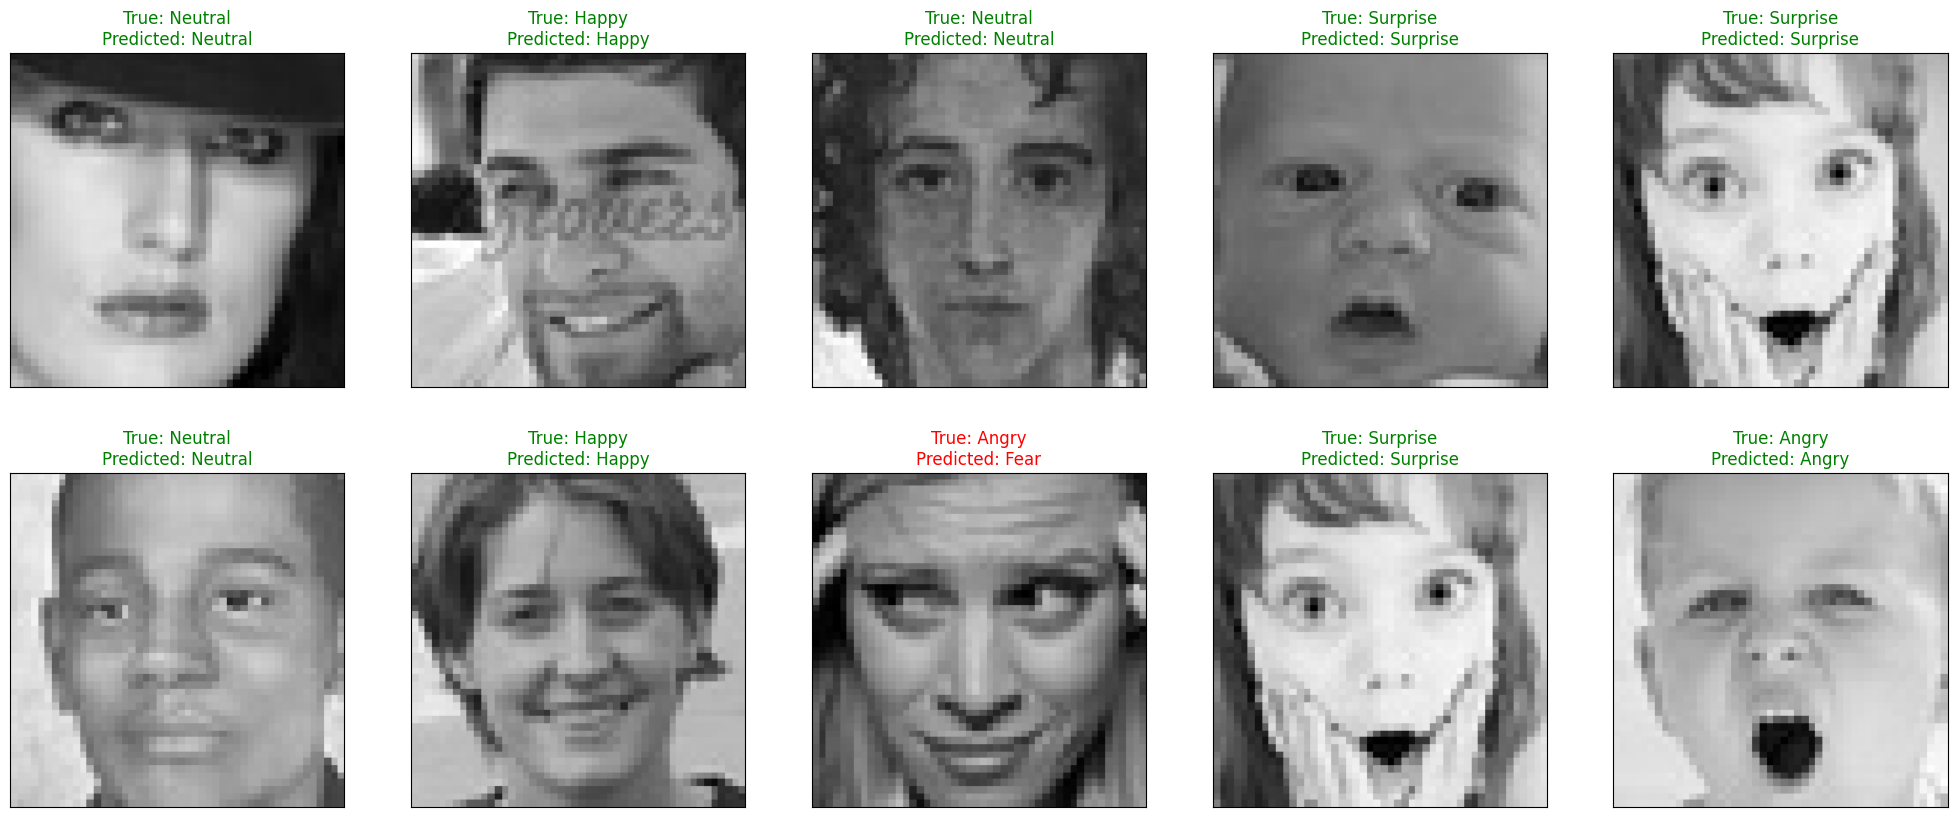

<Figure size 640x480 with 0 Axes>

In [20]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(ResNet50V2_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()

In [ ]:
def predicion1(url):
    img = plt.imread(url)
    plt.imshow(img)
    data = img_to_array(img)
    data = data/255
    data = tf.image.resize(data, (224, 224))
    samples = np.expand_dims(data, 0)
    samples = np.resize(samples, (1, 224, 224, 3))
    result = ResNet50V2_Model.predict(samples)
    result = list(result[0])
    print(result)
    predictions =  label_dict[np.argmax(result)]
    return predictions

1/1 [==============================] - 0s 93ms/step
[0.15210347, 0.0037692224, 0.2144734, 0.0024555936, 0.017138178, 0.60669976, 0.0033603779]


'Sad'

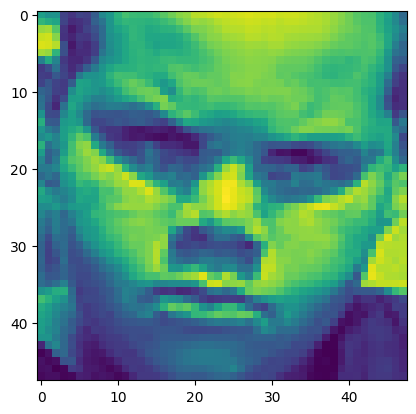

In [ ]:
predicion1("/content/test/sad/PrivateTest_5594100.jpg")

In [22]:
ResNet50V2_Model.save("ResNet50V2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
